## Load packages

In [19]:
pacman::p_load(
  stringr,
  limma,
  RColorBrewer,
  dplyr,
  data.table,
  ggplot2,
  ggrepel,
  ggrastr,
  seriation,
  magrittr,
  patchwork,
  scales,
  forcats
)

In [3]:
theme_set(theme_classic(base_size = 18) %+replace% theme(strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5)
))

## Load data

In [4]:
setwd("~/work/fibroblast_timecourse")

source("R/002_helper_functions.R")

In [5]:
fit1_top <- data.table::fread("gzip -cd analysis/limma/002_dose_limma_timefactor_dosefactor.tsv.gz")

In [10]:
dat <- reshape2::melt(
  data = dplyr::select(fit1_top, logFC, signif, ID, ensembl_id, Coef),
  id.vars = c("signif", "ID", "Coef", "ensembl_id")
) %>%
# filter(signif) %>%
data.table::dcast(formula = ID + ensembl_id ~ Coef, fun.aggregate = mean, value.var = "value") %>%
mutate(signif = abs(d10) > log2(2) | abs(t6) > log2(2))

#colnames(dat) <- c("Gene", "DoseFactor10", "TimeFactor10", "signif")

subset(dat, ID %in% c("ELF3", "CSF3", "POU2F2", "CXCL1", "CXCL8", "MMP1", "ICAM1"))

,ID,ensembl_id,Intercept,d1,d10,t10,t12,t18,t2,t24,t4,t6,t8,signif
5547,CSF3,ENSG00000108342,3.1720e-15,1.9202,3.3297,0.2947,0.3079,0.80170,-1.0283,1.2396,-0.4698,-0.1939,-0.0280,TRUE
5668,CXCL1,ENSG00000163739,1.5713e+00,3.6019,4.6875,6.3525,6.3977,6.34660,6.5649,6.3551,6.2818,6.2824,6.3267,TRUE
5680,CXCL8,ENSG00000169429,6.3180e-01,1.3469,1.8039,10.9978,11.1171,10.89080,8.5626,10.7012,9.8261,10.4191,10.8254,TRUE
6645,ELF3,ENSG00000163435,8.0760e-01,1.4482,2.4315,0.1919,0.2745,0.83900,-0.5674,0.9596,-0.0422,-0.0838,-0.0332,TRUE
9035,ICAM1,ENSG00000090339,3.3475e+00,-0.3027,-0.6195,6.1024,5.7718,4.87550,5.9629,4.5246,6.7512,6.6240,6.3932,TRUE
10887,MMP1,ENSG00000196611,4.0519e+00,0.2181,0.2765,6.4072,6.4222,6.90390,2.6748,7.3451,4.4194,5.4986,6.0622,TRUE
13290,POU2F2,ENSG00000028277,1.0900e+00,1.1779,1.7770,0.4057,0.7707,0.00118,-0.2927,0.3519,0.1084,0.6022,0.5003,TRUE


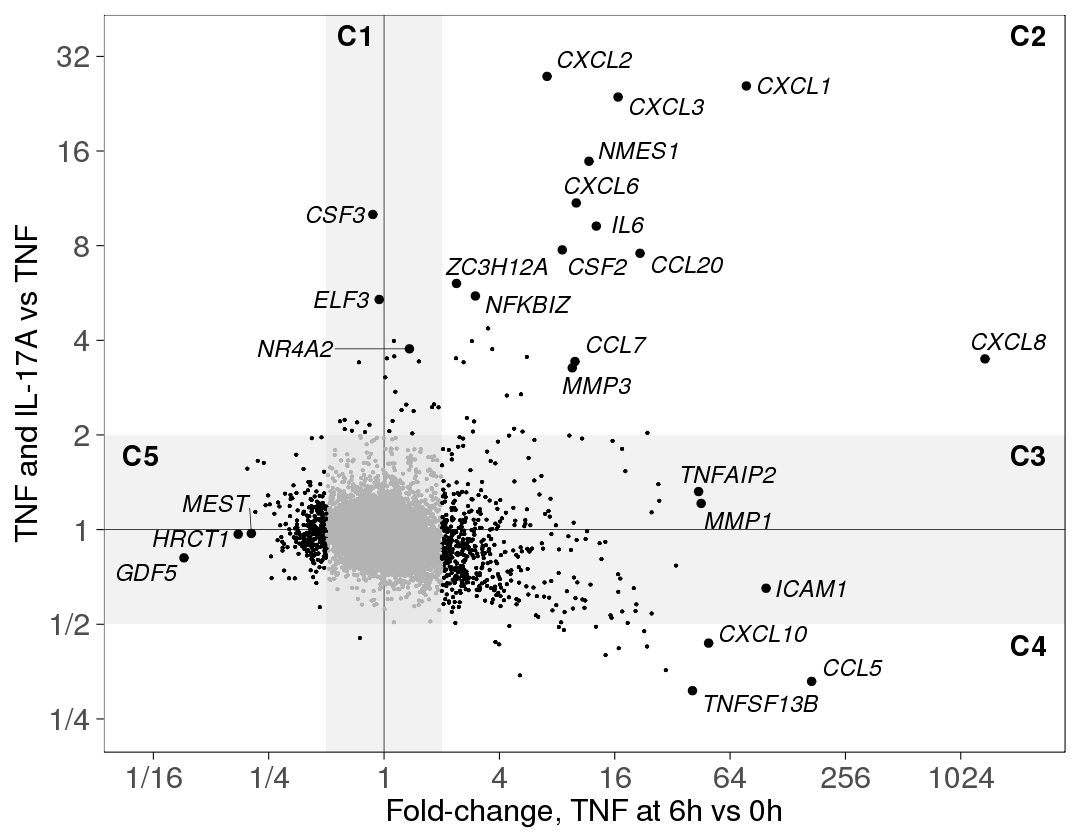

In [73]:
effect_x <- "t6"
effect_y <- "d10"

cat_colors <- rep(c("grey80", "white"), length.out = 5)
# cat_colors <- scico::scico(n = 5, palette = "roma")
cat_alpha  <- 0.25

labeled_genes <- c(
  "CSF3", "ELF3", "NR4A2", "GDF5", "HRCT1", "MEST", "CXCL1", "CXCL2", "CXCL3", "CXCL8", "ICAM1", "MMP1", "TNFAIP2", "TNFSF13B", "CCL5", "CXCL10",
  "C15orf48", "NMES1", "CXCL6", "CSF2", "IL6", "NFKBIZ", "ZC3H12A", "MMP3", "CCL7", "CCL20"
)

dat_text <- dat %>% filter(ID %in% labeled_genes)
# dat_text

d2 <- dat %>% filter(ID %in% labeled_genes | abs(t6) > 2 | abs(d10) > 2)
d2$ID <- ifelse(d2$ID %in% dat_text$ID, d2$ID, "")

d2$nudge_x <- 0
# lower right
d2$nudge_x[d2[[effect_x]] > log2(16) & d2[[effect_y]] < log2(2)] <- log2(1.25)
# left
d2$nudge_x[d2[[effect_x]] < log2(1/4)] <- log2(1/1.3)
# top middle
d2$nudge_x[d2[[effect_y]] > log2(2) & abs(d2[[effect_x]]) < 2] <- log2(1/1.6)
# top right
d2$nudge_x[d2[[effect_y]] > log2(2) & d2[[effect_x]] > 2] <- log2(1.2)
# manual override
d2$nudge_x[d2$ID == "NR4A2"] <- log2(1/4)
d2$nudge_x[d2$ID == "ZC3H12A"] <- log2(1.5)
d2$nudge_x[d2$ID == "NFKBIZ"] <- log2(1.5)
d2$nudge_x[d2$ID == "CCL5"] <- 0
d2$nudge_x[d2$ID == "CXCL8"] <- 0

# dat %>% filter(signif) %>%
p <- ggplot() +
annotate(
  geom = "rect",
  fill = "grey80", alpha = 0.25,
  xmin = -Inf, xmax = Inf, ymin = -log2(2), ymax = log2(2)
) +
annotate(
  geom = "rect",
  fill = "grey80", alpha = 0.25,
  ymin = -Inf, ymax = Inf, xmin = -log2(2), xmax = log2(2)
) +
geom_hline(yintercept = 0, size = 0.2) +
geom_vline(xintercept = 0, size = 0.2) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[1],
#   alpha = cat_alpha, color = NA,
#   ymin = log2(2), ymax = Inf, xmin = -log2(2), xmax = log2(2)
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[2],
#   alpha = cat_alpha, color = NA,
#   ymin = log2(2), ymax = Inf, xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[3],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[4],
#   alpha = cat_alpha, color = NA,
#   ymin = -Inf, ymax = -log2(2), xmin = log2(2), xmax = Inf
# ) +
# annotate(
#   geom = "rect",
#   fill = cat_colors[5],
#   alpha = cat_alpha, color = NA,
#   ymin = -log2(2), ymax = log2(2), xmin = -Inf, xmax = -log2(2)
# ) +
annotate(
  geom = "text", color = "black", label = "C1",
  y = Inf, x = -log(2.25), hjust = 0, vjust = 1.5, size = 6, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C2",
  y = Inf, x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C3",
  y = log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C4",
  y = -log2(2), x = Inf, hjust = 1.5, vjust = 1.5, size = 6, fontface = "bold"
) +
annotate(
  geom = "text", color = "black", label = "C5",
  y = log2(2), x = -Inf, hjust = -0.5, vjust = 1.5, size = 6, fontface = "bold"
) +
geom_point_rast(
  data = dat,
  mapping = aes_string(x = effect_x, y = effect_y, color = "signif"),
  size = 0.5, raster.width = 9, raster.height = 7
) +
geom_point(
#   data = dat_cat,
  data = dat_text,
  mapping = aes_string(x = effect_x, y = effect_y),
  size = 2
) +
geom_text_repel(
  seed = 42,
  data = d2,
  mapping = aes_string(x = effect_x, y = effect_y, label = "ID"),
  size = 5,
  box.padding = unit(0.35, "lines"),
  segment.size = 0.2,
  fontface = "italic",
  nudge_x = d2$nudge_x
) +
scale_color_manual(values = c("grey70", "black")) +
scale_y_continuous(expand = c(0.1, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(6)) +
scale_x_continuous(expand = c(0.1, 0), labels = function(x) fractional::fractional(2^x), breaks = scales::pretty_breaks(8)) +
theme(
  legend.position = "none",
  axis.text = element_text(size = 18),
  axis.title = element_text(size = 18)
) +
labs(x = "Fold-change, TNF at 6h vs 0h", y = "TNF and IL-17A vs TNF")

                   
options(repr.plot.width = 9, repr.plot.height = 7)

# p
show_plot(p, name = "figure1-scatter")